In [1]:
import open3d as o3d
import numpy as np
import json
from pathlib import Path
from scipy.spatial.transform import Rotation
from scipy.spatial import KDTree
from matplotlib import pyplot as plt
from matplotlib import animation
import time
import shutil
from tqdm import tqdm


## Load in data

Grab the transform and point cloud data from the data folder in order to animate it. Note that the point clouds are stored in homogeneous coordinates

In [2]:
rust_path_pc = Path(r"/Users/chrisvail/Documents/CruxTest/preprocessing/examples/output")
rust_path_transform = Path(r"/Users/chrisvail/Documents/CruxTest/matcher/examples/output/transforms/3")
# rust_path_pc = Path(r"C:\Users\chris\Documents\Work\Polymetrix\Rust\CruxTest\matcher\examples\data\2")
# rust_path_transform = Path(r"C:\Users\chris\Documents\Work\Polymetrix\Rust\CruxTest\matcher\examples\output\transforms\2")
transform_root = Path("./data/transforms/")
pc_root = Path("./data/frames/")

load_point_clouds = False

In [3]:
for f in transform_root.glob("*"):
    f.unlink()

for f in sorted(rust_path_transform.glob("*.json"), key=lambda x: int(x.stem[6:])):
    shutil.copyfile(f, transform_root / f.name)
params = []


In [4]:
if load_point_clouds:
    for f in pc_root.glob("frame*"): 
        f.unlink()
    for i,f in enumerate(sorted(rust_path_pc.glob("*.json"), key=lambda x: int(x.stem[6:]))):
        with open(f, "r") as pc_file:
            data = [item for row in json.load(pc_file)["frame"] for item in row if item["valid"]]
            pos, normal = list(zip(*[(x["position"], x["normal"]) for x in data]))
            pos, normal = np.array(pos), np.array(normal)

            np.save(pc_root / f"frame_{i:03d}", pos)



In [5]:

for file in sorted(transform_root.glob("*.json"), key=lambda x: int(x.stem[6:])):
    with open(file, "r") as f:
        params.append(np.array(json.load(f)))

In [6]:
def convert_params(x: np.array) -> np.array:
    rot = Rotation.from_euler("ZYX", x[3:])
    t = x[:3]

    rtn = np.eye(4)
    rtn[:3, :3] = rot.as_matrix()
    rtn[:3, -1] = t

    return rtn

transforms = [np.apply_along_axis(convert_params, 1, x) for x in params]

transforms[0].shape

(41, 4, 4)

In [7]:
pcs = []

for file in sorted(pc_root.glob("*.npy"), key=lambda x: int(x.stem[6:])):
    pc = np.load(file)
    pc = np.concatenate((pc, np.ones((pc.shape[0], 1))), 1)
    pcs.append(pc)

len(pcs), pcs[0].shape

(72, (158394, 4))

## Visualising the point cloud to make sure they make sense


[56]


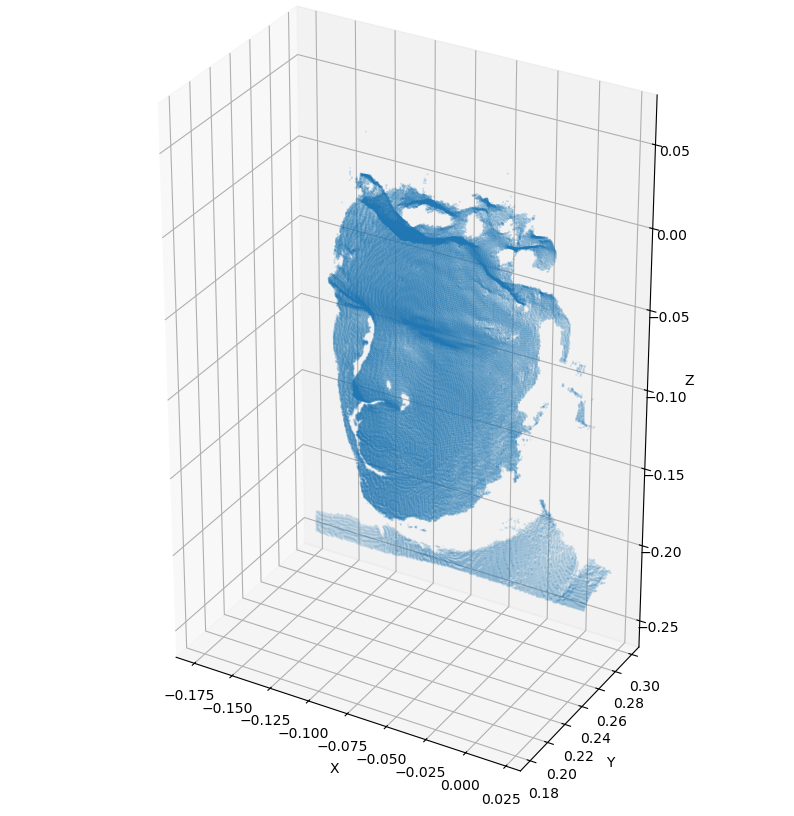

In [8]:
fig = plt.figure(figsize=(10,15))
num_plots = 1
rows, cols = 1, 1

plot_transform = np.eye(4)
plot_transform[:3, :3] = Rotation.from_euler("ZYX", [0, 0, -np.pi/2]).as_matrix()

idxs = np.random.choice([x for x in range(len(pcs))], num_plots)
print(idxs)

for i, idx in enumerate(idxs):
    pc = pcs[idx].copy()
    # (4, 4) @ (n, 4, 1)
    pc = plot_transform@pc[..., None]

    ax = fig.add_subplot(cols, rows, i + 1, projection="3d")
    ax.set_box_aspect((np.ptp(pc[:,0]), np.ptp(pc[:,1]), np.ptp(pc[:,2])))
    ax.scatter(pc[:,0], pc[:,1], pc[:,2], s=0.01)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

plt.show()



## Animation
Here we're going to attempt to animate the ICP process using matplotlib which is going to be interesting to say the least

In [9]:
pcs[0][np.random.choice(range(pcs[0].shape[0]), 2**4)]

array([[-0.1025047 , -0.01481131,  0.21166764,  1.        ],
       [-0.06764964,  0.02781457,  0.198986  ,  1.        ],
       [-0.05324836, -0.00188778,  0.20170414,  1.        ],
       [-0.0017202 ,  0.07775989,  0.20260185,  1.        ],
       [ 0.00202604,  0.07568025,  0.20546328,  1.        ],
       [-0.06413402,  0.1231044 ,  0.21065775,  1.        ],
       [-0.03639639, -0.00568491,  0.20472093,  1.        ],
       [-0.12147234,  0.02215118,  0.22329494,  1.        ],
       [-0.05453699,  0.15357544,  0.21856214,  1.        ],
       [-0.0378022 ,  0.04062389,  0.21019933,  1.        ],
       [-0.08637266,  0.00647285,  0.20779903,  1.        ],
       [-0.02984053, -0.03085556,  0.22361688,  1.        ],
       [-0.07247227,  0.05972176,  0.20537043,  1.        ],
       [-0.07408939,  0.02914078,  0.20123595,  1.        ],
       [-0.08831047,  0.03351685,  0.20765437,  1.        ],
       [-0.02062061,  0.14172007,  0.22158445,  1.        ]])

In [10]:
# from typing import Any


# fig = plt.figure(figsize=(15,10))
# ax = fig.add_subplot(1,1,1, projection="3d")


# def init():
#     return ()

# class Animator:
#     def __init__(self, source, target, transforms, fig, ax, plot_transform):
#         self.source = source
#         self.target = target
#         self.transforms = transforms
#         self.fig = fig
#         self.ax = ax
#         self.plot_transform = plot_transform

#     def __call__(self, i) -> tuple[Any]:
#         tree = KDTree(self.target[:,:3])
#         samples = self.source[np.random.choice(self.source.shape[0], 2**14),:3]
#         rmse = np.sqrt((np.array(tree.query(samples)[0])**2).mean())
#         frob = np.linalg.norm(np.eye(4) - self.transforms[i], ord='fro')
#         print(f"<{i}> Fro Norm: {frob} \tRMSE: {rmse*1000}mm")
#         ax.clear()
#         source = self.source[..., None]
#         source = self.plot_transform@source

#         ax.scatter(source[:, 0], source[:, 1], source[:, 2], s=0.005, c="b")
        
#         target = self.target[..., None]
#         target = self.transforms[i]@target
#         target = self.plot_transform@target

#         ax.scatter(target[:, 0], target[:, 1], target[:, 2], s=0.005, c="r")

#         tot = np.concatenate((target, source), 0)

#         ax.set_box_aspect((np.ptp(tot[:,0]), np.ptp(tot[:,1]), np.ptp(tot[:,2])))


# transforms_fake = np.array([np.eye(4), plot_transform, plot_transform@plot_transform, plot_transform@plot_transform@plot_transform])
# print(transforms_fake.shape)
# transforms_fake = np.concatenate((transforms_fake, transforms_fake, transforms_fake, transforms_fake), axis=0)
# print(transforms_fake.shape)


# start = 16
# print(pcs[start].shape, pcs[start + 1].shape, transforms[start].shape)

# animator = Animator(pcs[start], pcs[start + 1], transforms[start], fig, ax, plot_transform)

# anim = animation.FuncAnimation(animator.fig, animator, len(transforms[start]))

# anim.save(Path(f"./icp_test_{time.strftime('%Y_%m_%d-%H_%M_%S')}.mp4"), fps=10)

In [11]:
np.repeat(np.eye(4)[None], 8, axis=0).shape

(8, 4, 4)

12 (11, 2)
Animation length: 454


100%|██████████| 454/454 [02:24<00:00,  1.79it/s]

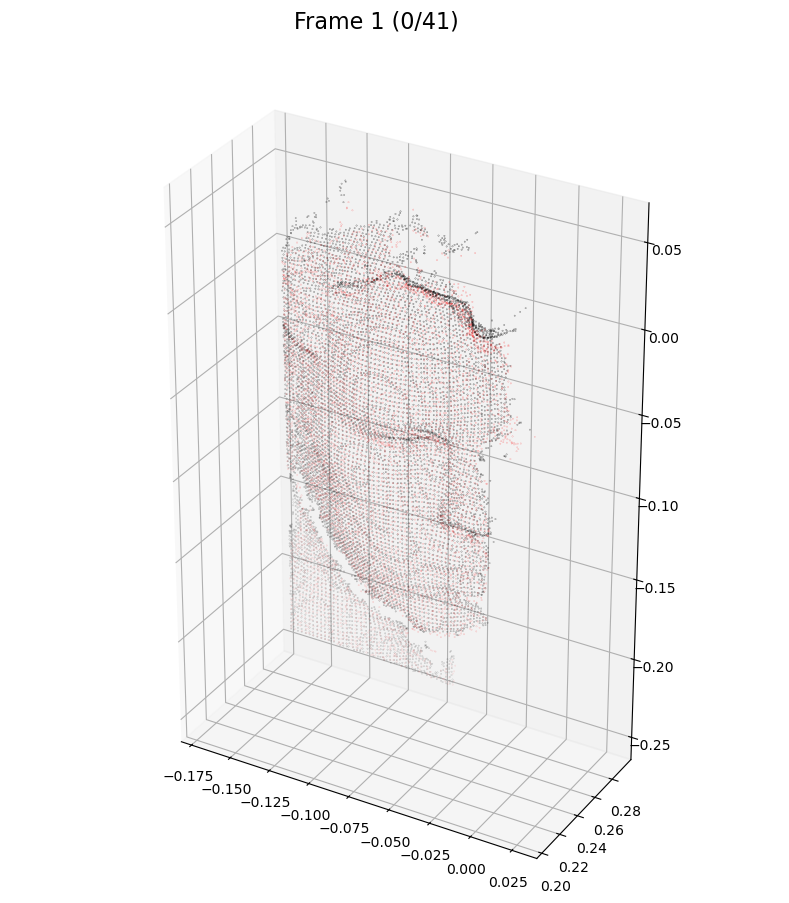

In [16]:
from copy import deepcopy
from functools import lru_cache
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection="3d")

class FullAnimator:
    def __init__(self, pcs, transforms, fig, ax, plot_transform):
        self.transform_map = [(i, j) for i, (trans, pc) in enumerate(zip(transforms, pcs)) for j in range(0, trans.shape[0])]
        self.pcs = pcs
        self.transforms = transforms
        self.fig = fig
        self.ax = ax
        self.plot_transform = plot_transform
        self.transform_len = transforms[0].shape[0]

        self.targets = self.get_targets()
        self.mins = np.min(self.targets[-1], 0)
        self.maxs = np.max(self.targets[-1], 0)
        self.ptp = (np.ptp(self.targets[-1][:,0]), np.ptp(self.targets[-1][:,1]), np.ptp(self.targets[-1][:,2]))        

    def __call__(self, i):

        index, frame = self.transform_map[i]
        transform = self.transforms[index][frame]
        target = deepcopy(self.targets[index][:,:])
        source = deepcopy(self.pcs[index + 1])

        self.ax.clear()
        source = FullAnimator.down_sample(self.plot_transform@transform@source[...,None], 1E-3)
        self.ax.scatter(source[:, 0], source[:, 1], source[:, 2], s=0.03, c="k")

        self.ax.scatter(target[:, 0], target[:, 1], target[:, 2], s=0.01, c="r")
        self.ax.set_box_aspect(self.ptp)
        self.ax.set_xlim(self.mins[0], self.maxs[0])
        self.ax.set_ylim(self.mins[1], self.maxs[1])
        self.ax.set_zlim(self.mins[2], self.maxs[2])
        self.fig.suptitle(f"Frame {index + 1} ({frame}/{transforms[index].shape[0]})", fontsize=16)


    def get_targets(self, samples_per_frame=2**14):
        targets = []
        target = None
        for i, pc in enumerate(self.pcs[:self.transform_map[-1][0]+1]):
            if target is None:
                target = (self.plot_transform@pc[np.random.choice(pc.shape[0], samples_per_frame),:,None]).squeeze()
                targets.append(target[:,:])
            else:
                points = (self.plot_transform@self.transforms[i - 1][-1]@pc[np.random.choice(pc.shape[0], samples_per_frame),:,None]).squeeze()
                target = np.concatenate((target, points), 0)
                targets.append(target[:,:])
        
        print(len(targets), self.transform_map[-1])
        return [FullAnimator.down_sample(t) for t in targets]

    def down_sample(t, voxel_size=2.5E-3):
        cloud = o3d.geometry.PointCloud()
        cloud.points = o3d.utility.Vector3dVector(t[:,:3])
        try:
            cloud = cloud.voxel_down_sample(2.5E-3)
        except Exception:
            pass
        return np.asarray(cloud.points)
                
    def __len__(self):
        return len(self.transform_map)

animator = FullAnimator(pcs[:], transforms[:], fig, ax, plot_transform)

print(f"Animation length: {len(animator)}")

anim = animation.FuncAnimation(animator.fig, animator, len(animator))

progress_bar = tqdm(total=len(animator), position=0, leave=True)

def progress_callback(current_frame, total_frames):
    progress_bar.update(1)
    if current_frame == total_frames:
        progress_bar.close() 

anim.save(Path(f"./videos/icp_test_{time.strftime('%Y_%m_%d-%H_%M_%S')}.mp4"), fps=20, progress_callback=progress_callback)

In [ ]:
pc = o3d.geometry.PointCloud()
pc.points = o3d.utility.Vector3dVector(animator.targets[24])

# o3d.visualization.draw_geometries([pc])